In [1]:
import uproot as uproot
import numpy as np

### Reading the data

In [2]:
root_file = uproot.open('data/0001.root')
nevents=None

# Наблюдаемые величины
RawE = root_file['ecalNT']['RawEnergyDeposit'].arrays(library='np')['RawEnergyDeposit'][:nevents]
x = root_file['ecalNT']['RawX'].arrays(library='np')['RawX'][:nevents]
y = root_file['ecalNT']['RawY'].arrays(library='np')['RawY'][:nevents]
z = root_file['ecalNT']['RawZ'].arrays(library='np')['RawZ'][:nevents]
EnergyDeposit = [img.reshape(15,15)[None,:,:] for img in np.array(root_file['ecalNT']['EnergyDeposit'].array()[:nevents])]

# Величины на входе симулятора
ParticlePDG = np.array(root_file['ecalNT']['ParticlePDG'].array())[:nevents]
ParticleMomentum_v = np.array(root_file['ecalNT']['ParticleMomentum'].array())[:nevents]
ParticleMomentum = np.sum(ParticleMomentum_v * ParticleMomentum_v, axis=1) ** 0.5

### Baseline for momentum prediction

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [60]:
# Preprocess the data
X = np.array(EnergyDeposit).reshape(len(EnergyDeposit), -1)  # Flatten the energy deposits
y = ParticleMomentum  # Continuous target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression(positive=True)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Mean Squared Error: 0.6631082902436318
R-squared: 0.9991884831013897


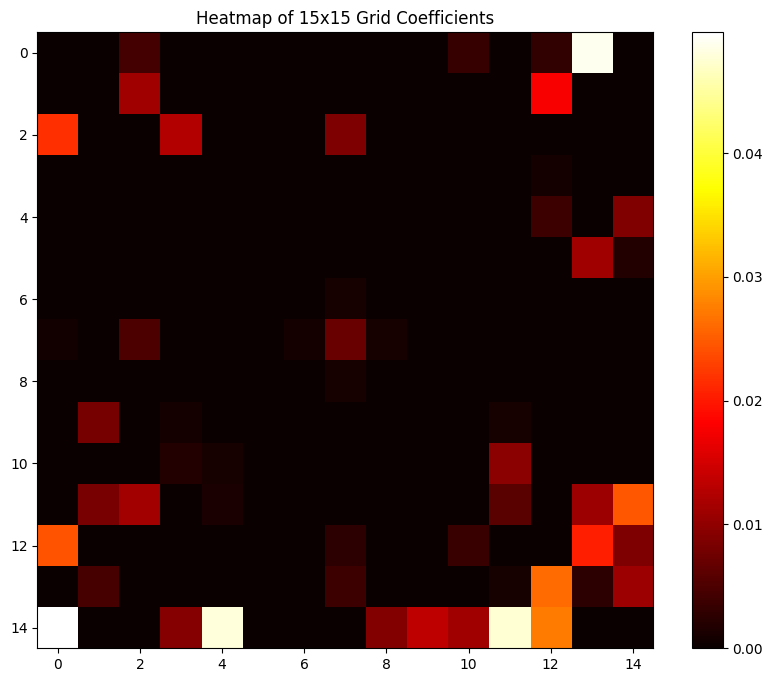

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(model.coef_.reshape(15, 15), cmap='hot', interpolation='nearest')
plt.title("Heatmap of 15x15 Grid Coefficients")
plt.colorbar()
plt.show()

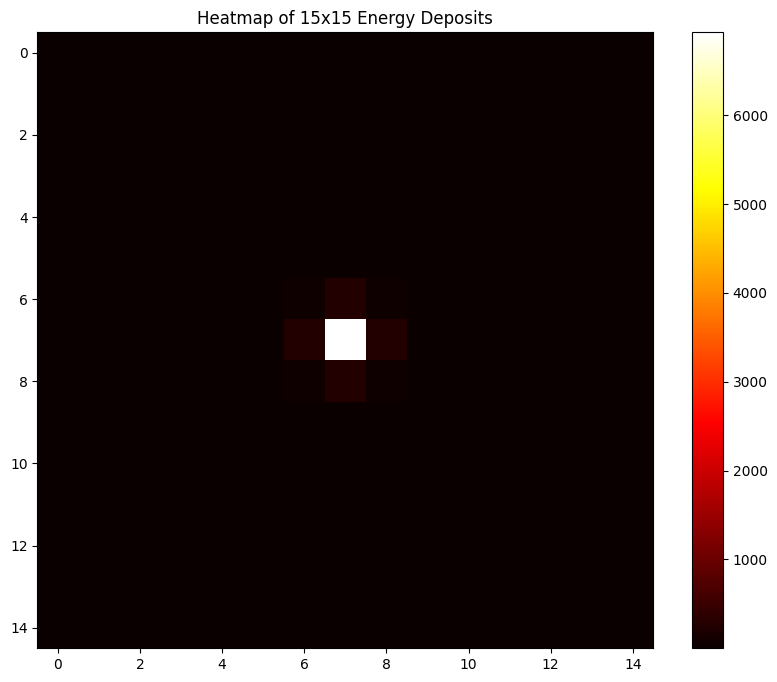

In [27]:
plt.figure(figsize=(10, 8))
plt.imshow(np.mean(X_train, axis=0).reshape(15, 15), cmap='hot', interpolation='nearest')
plt.title("Heatmap of 15x15 Energy Deposits")
plt.colorbar()
plt.show()

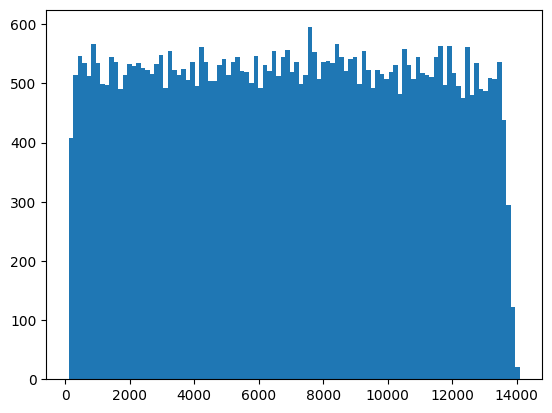

In [46]:
plt.hist(X_train[:, 112], bins=100, )

plt.show()

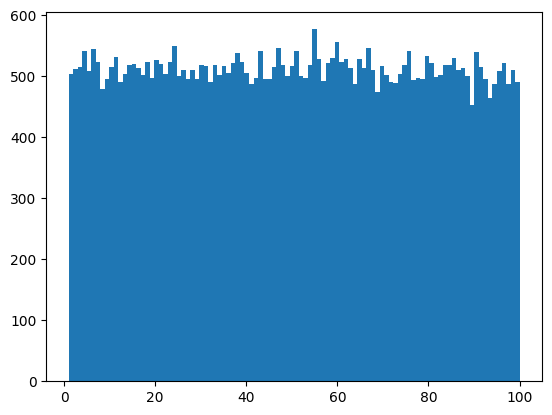

In [38]:
plt.hist(y_train, bins=100)

plt.show()

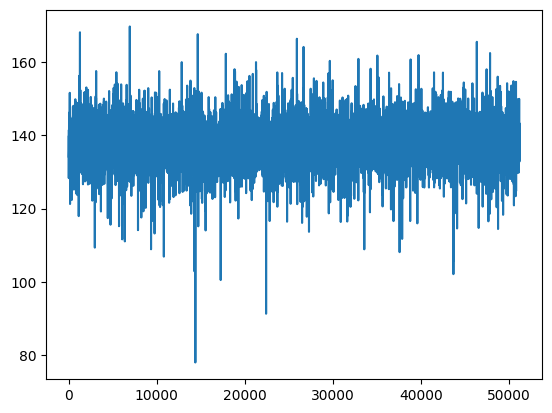

In [39]:
plt.plot(X_train[:, 112] / y_train)

plt.show()

### Catboost for momentum prediction

In [5]:
from catboost import CatBoostRegressor

model = CatBoostRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

KeyboardInterrupt: 

### Experiments

In [10]:
X = np.array(EnergyDeposit).reshape(len(EnergyDeposit), -1)
y = ParticleMomentum

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(np.exp(y_test), np.exp(y_pred)))
print("R-squared:", r2_score(y_test, y_pred))

Mean Squared Error: 0.6618714534303338
Mean Squared Error: 1.6186161394414718e+85
R-squared: 0.9991899967515576


In [12]:
from sklearn.svm import SVR

model = SVR()
model.fit(X_train[:5000], y_train[:5000])

y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Mean Squared Error: 0.767115112782397
R-squared: 0.9990611987719631
